In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Homework №1

# Dataset
We're just loading it here. There is some Torch transformation magic, but we'll discuss in the next class.


### Some magical dataset transformations you don't need to think about for now
1. Image to tensor conversion
2. Image normalization

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Loading the dataset
This particular part of the code is used once and only in this homework.

In [7]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Converting into two classes
This is necessary to simplify the task to binary classification. In this homework we will distinguish only two numbers: 3 and 7.

In [8]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Wrapping it in a data iterator
Later in the course we will talk about what this is in more detail, but there are some useful details further in this notebook.

For now it is enough to understand that we have wrapped our data in some abstraction, the iteration of which gives us batches of data from our dataset.

In [9]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Data visualization

- class 0 corresponds to number 3
- class 1 corresponds to number 7

I chose these numbers because they have the worst metrics

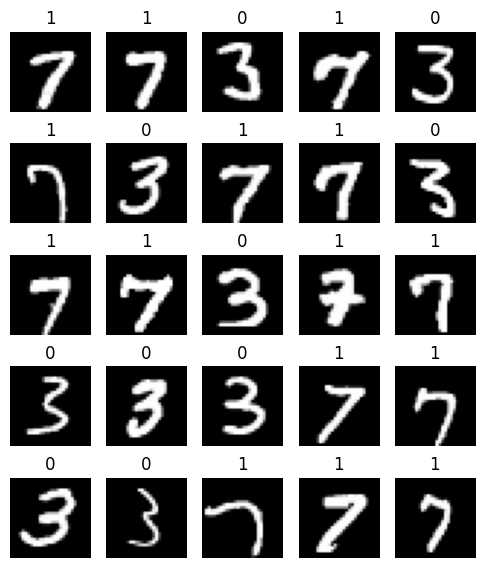

In [10]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Iterating over the dataset
- x is batch with data
- y is batch with targets for this data

In [11]:
for x, y in train_loader:
    break

### train_loader is an iterator that will produce batches of data

## Dimensions of x
- 128 is a batch size
- 1 is a number of channels, we have black and white images, so the number of channels is 1
- 28 is a number of pixels in length
- 28 is a number of pixels in width

In [12]:
x.shape

torch.Size([128, 1, 28, 28])

In [13]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Let's just flatten our matrix into one vector
### That is, each feature in the vector is a pixel value
### For our toy task, this will be enough

In [14]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
This is a conversion of a Torch tensor (some abstraction that we will talk about later in the course) into a numpy array.

In [15]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [16]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Dimensionality
- number of examples in a batch
- number of features

In [17]:
x.shape

(128, 784)

# Targets
- class 0 corresponds to number 3
- class 1 corresponds to number 7

In [18]:
y

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

# Iteration over epochs

In [19]:
# number of epochs (i.e. full passes through the dataset)
epochs = 3

for n_epoch in range(epochs):

    dataset_passed_samples = 0

    for x, y in train_loader:

        # here we could somehow manipulate the data
        # for example, teach, but we won't do that for now
        # this is just a demonstration

        time.sleep(0.01)

        dataset_passed_samples += x.shape[0]

        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]

        print(f'Epoch - {n_epoch + 1}, passed - {dataset_passed_percent:.2f} % of the dataset', end='\r')

    print('\r')

Epoch - 1, passed - 100.00 % of the dataset
Epoch - 2, passed - 100.00 % of the dataset
Epoch - 3, passed - 100.00 % of the dataset


# Some explanation about numpy

In [20]:
# this is how we create a 64 by 512 matrix with random values
x = np.random.rand(64, 512)
x

array([[0.02490264, 0.69174046, 0.63094107, ..., 0.70653833, 0.78577571,
        0.31402253],
       [0.31238187, 0.57307471, 0.94102293, ..., 0.64782567, 0.94908163,
        0.37344759],
       [0.65699941, 0.72231188, 0.91767694, ..., 0.54905423, 0.40400753,
        0.69348175],
       ...,
       [0.73133141, 0.34557845, 0.10743808, ..., 0.91117944, 0.57757612,
        0.81829337],
       [0.94063805, 0.41083433, 0.26651273, ..., 0.98579261, 0.75712064,
        0.48057467],
       [0.93992016, 0.77632463, 0.91465518, ..., 0.1396441 , 0.70244462,
        0.06447819]])

In [21]:
# most functions are applied to each element of the array
# here we squared each element of the array and added the logarithm of the matrix element to the resulting value
x ** 2 + np.log(x)

array([[-3.69216112,  0.10996041, -0.06245617, ...,  0.15181859,
         0.3763596 , -1.05968039],
       [-1.06594645, -0.22832455,  0.82473637, ..., -0.01445554,
         0.84849549, -0.8455145 ],
       [ 0.01157606,  0.19643618,  0.75622109, ..., -0.29809752,
        -0.74309967,  0.11488658],
       ...,
       [ 0.22195708, -0.94311112, -2.21929762, ...,  0.73723255,
        -0.21532085,  0.46906968],
       [ 0.82360309, -0.7207804 , -1.25130423, ...,  0.95747778,
         0.29499899, -0.50182065],
       [ 0.82148956,  0.34949543,  0.74738596, ..., -1.94915774,
         0.14023972, -2.7372708 ]])

In [22]:
y = np.random.rand(512, 1024)
# scalar product
res = np.dot(x, y)

In [23]:
res

array([[132.46537191, 123.39038909, 133.35625552, ..., 125.526831  ,
        131.47955691, 130.32958958],
       [134.71902817, 126.87158481, 133.11692718, ..., 128.44032027,
        132.68091354, 131.77019635],
       [134.91312365, 129.53530309, 134.81980986, ..., 131.89988174,
        131.88173594, 130.06914658],
       ...,
       [129.73298565, 126.79653864, 132.22889238, ..., 125.34863035,
        129.70627044, 129.13796373],
       [134.37321378, 123.79464877, 128.15334147, ..., 123.86750515,
        126.1992039 , 127.52136305],
       [136.41584556, 132.00046109, 137.41647681, ..., 134.26494451,
        136.29944194, 135.0997522 ]])

In [24]:
res.shape == (x.shape[0], y.shape[1])

True

### Linear layer derivatives
We know that we will need to update these weights by the gradients of the weights. That is, this is simply a shift of our weights by some step. It follows that the dimensions of the weights and the gradient to them must match. Use the scalar product, matrix transposition, and previous gradient for this.
The dimension of any parameter must match the dimension of the gradient to this parameter. In the case of the b parameters, we remember that this is a shift and, in fact, this is adding a feature with a single value to our input features.

```python
grad_w = np.dot(x.T, grad_prev)
grad_x = np.dot(grad_prev, w.T)
grad_b = np.dot(np.ones((x.shape[0])), grad_prev)
```

More detailed advice:  
Tip: use dimension analysis! Note that you do not need to remember the expressions for dW and dX because they are easy to re-derive based on dimensions. For instance, we know that the gradient on the weights dW must be of the same size as W after it is computed, and that it must depend on matrix multiplication of X and dD (as is the case when both X,W are single numbers and not matrices). There is always exactly one way of achieving this so that the dimensions work out. For example, X is of size [10 x 3] and dD of size [5 x 3], so if we want dW and W has shape [5 x 10], then the only way of achieving this is with np.dot(dD, X.T), as shown above.  
[Source](https://cs231n.github.io/optimization-2/)

Useful videos:  
- [One](https://www.coursera.org/lecture/intro-to-deep-learning/multilayer-perceptron-mlp-yy1NV)
- [Two](https://www.coursera.org/lecture/intro-to-deep-learning/chain-rule-rK0tw)
- [Three](https://www.coursera.org/lecture/intro-to-deep-learning/backpropagation-CxUe5)
- [Four](https://www.coursera.org/lecture/intro-to-deep-learning/efficient-mlp-implementation-P3VH6)
- [Five](https://www.coursera.org/lecture/intro-to-deep-learning/other-matrix-derivatives-YTunl)

# Task

### Steps:
1. Set the trainable parameters (TIP: np.random.rand)
1. Set the learning rate (0.01 will do, but you can try others and see what changes), the number of epochs (full passes through the dataset)
1. Make a linear transformation through the first layer (the first set of weights)
1. Apply some nonlinear activation function (tanh, relu)
1. Make a linear transformation through the second layer (the second set of weights)
1. Apply sigmoid
1. Calculate the loss function (binary cross entropy), do not forget to average over the batch
1. Save the values ​​of the loss function in the 'losses' array
1. Take derivatives of the loss function for each trainable parameter [video about derivatives](https://youtu.be/tZ0yCzWfbZc)
1. Update the weights w1, b1, w2, b2 using the gradient descent
1. Visualize the loss function

- TIP: the number of input features is 784 (28 pixels * 28 pixels)
- TIP: in step 0, multiply w1, w2 by 0.01, and initialize b1, b2 to zeros. This is not the best implementation, but we don't know a better way yet
- TIP: in backward, the loss function for your model's predictions needs to be divided by the number of examples in the batch (don't forget that you are averaging the loss)
- TIP: calculate each subsequent gradient by multiplying by the previous one, that is, you don't need to calculate for each layer and then merge everything. You need to calculate the gradient for d_L/d_z2 as d_L/d_y_hat multiplied by d_y_hat/d_z2 at once, where y_hat is our predictions.

## If you find it difficult, do it for one layer first

## Hints for dimensions

### Forward

- z1 - first linear transformation - (BATCH_SIZE, INNER_FEATURES)
- a1 - nonlinearity application - (BATCH_SIZE, INNER_FEATURES)
- z2 - second nonlinear transformation - (BATCH_SIZE, 1)
- pred - sigmoid - (BATCH_SIZE, 1)
- loss - loss function - scalar

### Backward

- d_loss/d_pred - gradient of loss function by pred - (BATCH_SIZE, 1)
- d_loss/dz2 - gradient of sigmoid by z2 - (BATCH_SIZE, 1)
- d_loss/da1 - gradient of linear transformation by a1 - (BATCH_SIZE, INNER_FEATURES)
- d_loss/dw2 - gradient of linear transformation by w2 - (INNER_FEATURES, 1)
- d_loss/db2 - gradient of linear transformation by b2 - (1,)
- d_loss/dz1 - gradient of nonlinear function by z1 - (BATCH_SIZE, INNER_FEATURES)
- d_loss/dw1 - gradient of linear transformation by w1 - (IN_FEATURES, INNER_FEATURES)
- d_loss/db1 - gradient of linear transformation by b1 - (INNER_FEATURES,)


# You need to get a loss value below 0.1 (on the graph)
```np.mean(losses)``` should be approximately 0.15

This is somewhere around 0.9+ accuracy

### **First Attempt**

Epoch: 1
Epoch: 2
Epoch: 3


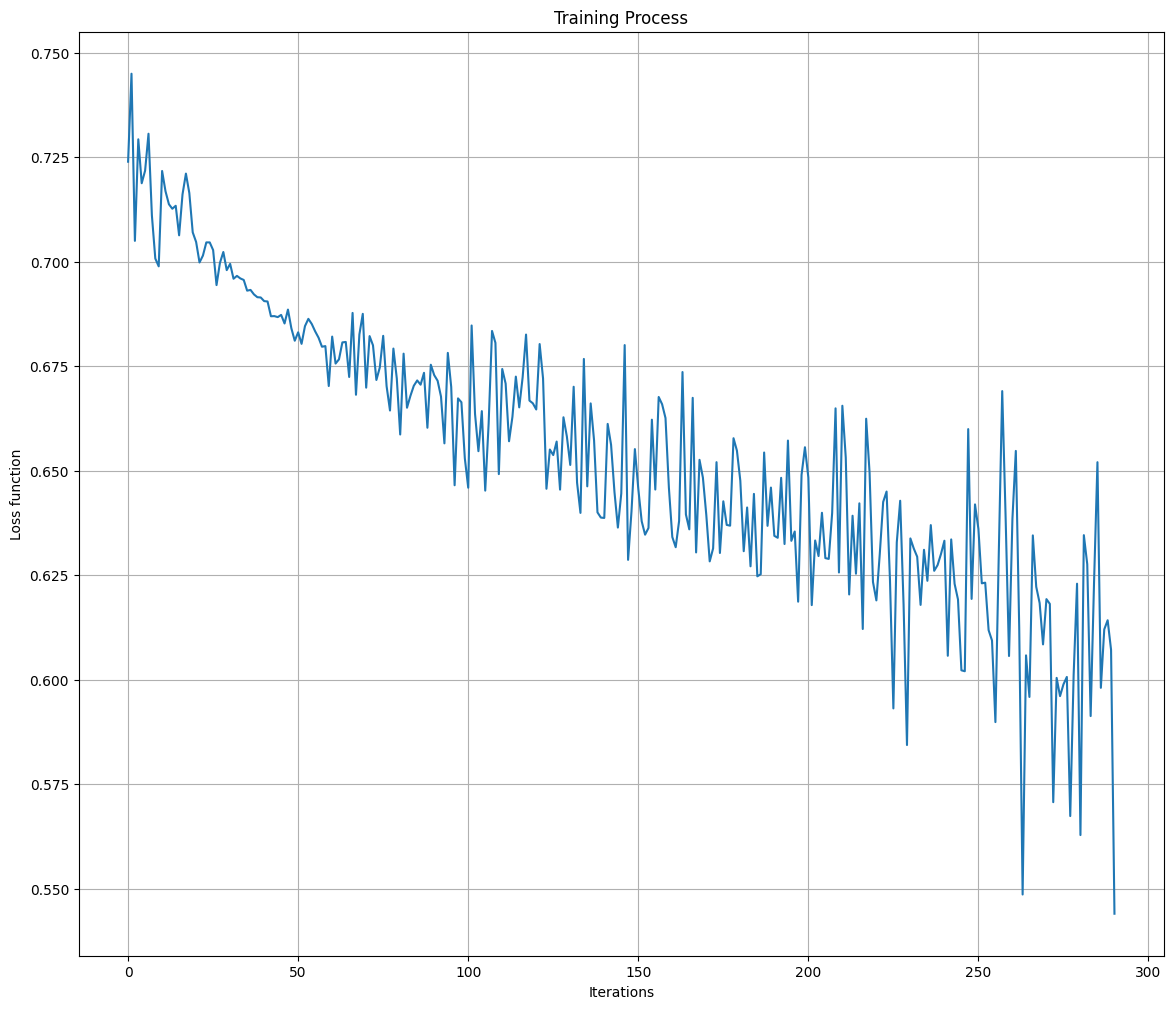

Final Loss: 0.6546


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters
learning_rate = 0.01
epochs = 3
input_size = 28 * 28  # Number of input features (784 pixels)
hidden_size = 128     # Number of hidden neurons (you can adjust this)
output_size = 1       # Binary classification output

# Initialize weights and biases
np.random.seed(42)
w1 = 0.01 * np.random.rand(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
w2 = 0.01 * np.random.rand(hidden_size, output_size)
b2 = np.zeros((1, output_size))

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Binary cross-entropy loss function
def binary_cross_entropy(y_true, y_pred):
    # Clipping to avoid log(0) errors
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Derivative of ReLU
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Training loop
losses = []

for n_epoch in range(epochs):
    print(f'Epoch: {n_epoch + 1}')

    for x, y in train_loader:
        # Flatten input images
        x = x.view(x.shape[0], -1).numpy()  # (batch_size, 784)
        y = np.expand_dims(y.numpy(), 1)    # (batch_size, 1)

        # Forward pass
        z1 = np.dot(x, w1) + b1             # Linear transformation
        a1 = relu(z1)                       # ReLU activation
        z2 = np.dot(a1, w2) + b2            # Second linear transformation
        pred = sigmoid(z2)                  # Sigmoid activation (output)

        # Loss calculation
        loss = binary_cross_entropy(y, pred)
        losses.append(loss)

        # Backward pass (gradients)
        d_loss_pred = (pred - y) / x.shape[0]     # Gradient of loss w.r.t. predictions
        d_loss_z2 = d_loss_pred * sigmoid_derivative(z2)  # Gradient of sigmoid
        d_loss_w2 = np.dot(a1.T, d_loss_z2)             # Gradient of weights w2
        d_loss_b2 = np.sum(d_loss_z2, axis=0, keepdims=True)  # Gradient of biases b2

        d_loss_a1 = np.dot(d_loss_z2, w2.T)              # Gradient of a1
        d_loss_z1 = d_loss_a1 * relu_derivative(z1)      # Gradient of ReLU
        d_loss_w1 = np.dot(x.T, d_loss_z1)               # Gradient of weights w1
        d_loss_b1 = np.sum(d_loss_z1, axis=0, keepdims=True)  # Gradient of biases b1

        # Update weights and biases
        w2 -= learning_rate * d_loss_w2
        b2 -= learning_rate * d_loss_b2
        w1 -= learning_rate * d_loss_w1
        b1 -= learning_rate * d_loss_b1

# Plotting the loss function over epochs
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training Process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.show()

# Check if the loss is below 0.1
print(f'Final Loss: {np.mean(losses):.4f}')

### **Second Attempt**

Epoch: 1


100%|██████████| 97/97 [00:05<00:00, 16.89it/s]


Epoch: 2


100%|██████████| 97/97 [00:04<00:00, 23.38it/s]


Epoch: 3


100%|██████████| 97/97 [00:06<00:00, 15.63it/s]


Epoch: 4


100%|██████████| 97/97 [00:04<00:00, 23.33it/s]


Epoch: 5


100%|██████████| 97/97 [00:04<00:00, 23.01it/s]


Epoch: 6


100%|██████████| 97/97 [00:06<00:00, 15.89it/s]


Epoch: 7


100%|██████████| 97/97 [00:04<00:00, 23.48it/s]


Epoch: 8


100%|██████████| 97/97 [00:04<00:00, 22.32it/s]


Epoch: 9


100%|██████████| 97/97 [00:05<00:00, 16.38it/s]


Epoch: 10


100%|██████████| 97/97 [00:04<00:00, 23.08it/s]


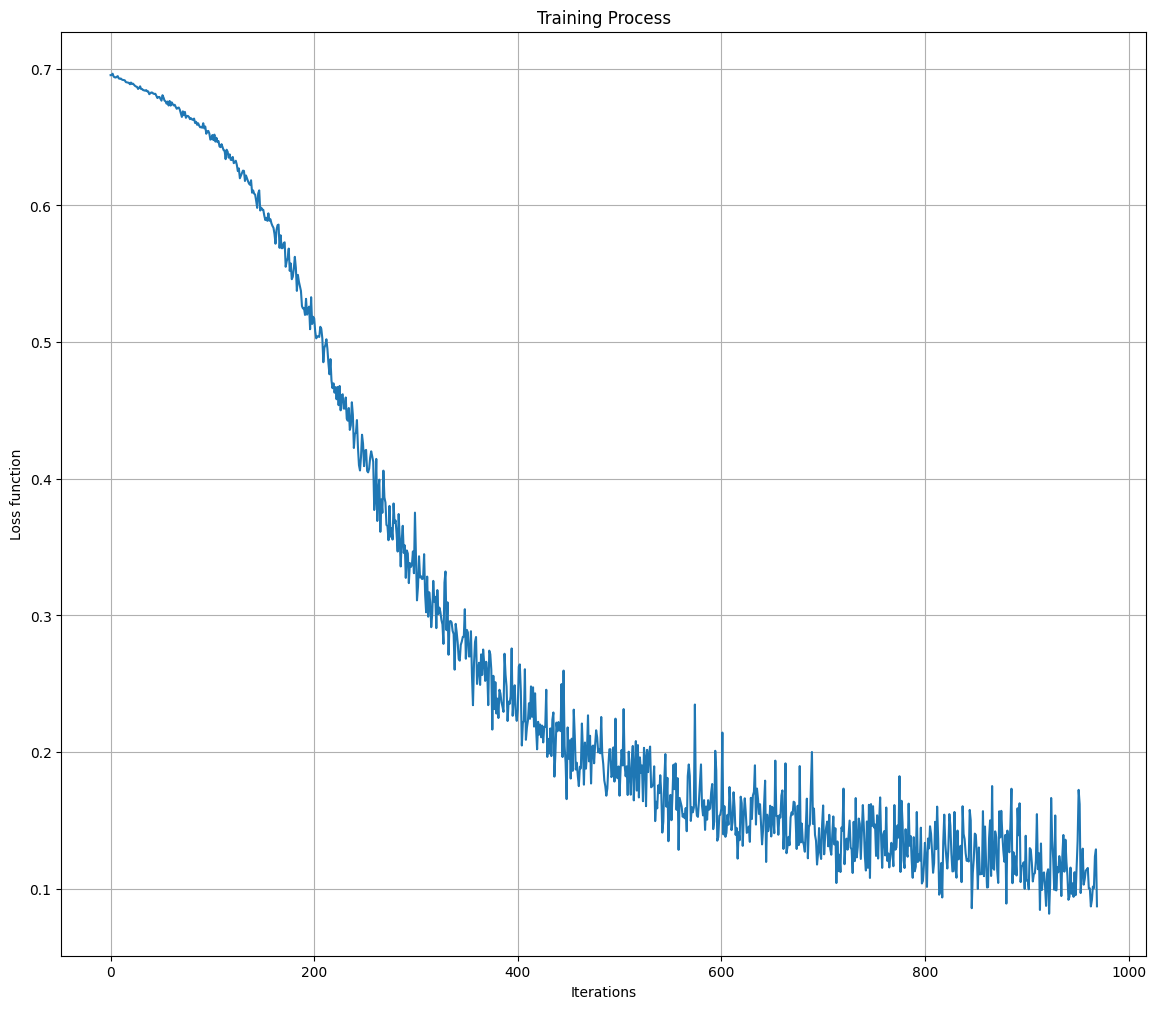

Final Mean Loss: 0.1183


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters
learning_rate = 0.01
epochs = 10   # More epochs to get better training results
input_size = 28 * 28  # Number of input features (784 pixels)
hidden_size = 128     # Number of hidden neurons (can be adjusted)
output_size = 1       # Binary classification output

# Initialize weights and biases
np.random.seed(42)
w1 = 0.01 * np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
w2 = 0.01 * np.random.randn(hidden_size, output_size)
b2 = np.zeros((1, output_size))

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Binary cross-entropy loss function
def binary_cross_entropy(y_true, y_pred):
    # Clipping to avoid log(0) errors
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Derivative of ReLU
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Training loop
losses = []

for n_epoch in range(epochs):
    print(f'Epoch: {n_epoch + 1}')

    for x, y in tqdm(train_loader):
        # Flatten input images
        x = x.view(x.shape[0], -1).numpy()  # (batch_size, 784)
        y = np.expand_dims(y.numpy(), 1)    # (batch_size, 1)

        # Forward pass
        z1 = np.dot(x, w1) + b1             # Linear transformation
        a1 = relu(z1)                       # ReLU activation
        z2 = np.dot(a1, w2) + b2            # Second linear transformation
        pred = sigmoid(z2)                  # Sigmoid activation (output)

        # Loss calculation
        loss = binary_cross_entropy(y, pred)
        losses.append(loss)

        # Backward pass (gradients)
        d_loss_pred = (pred - y) / x.shape[0]     # Gradient of loss w.r.t. predictions
        d_loss_z2 = d_loss_pred * sigmoid_derivative(z2)  # Gradient of sigmoid
        d_loss_w2 = np.dot(a1.T, d_loss_z2)             # Gradient of weights w2
        d_loss_b2 = np.sum(d_loss_z2, axis=0, keepdims=True)  # Gradient of biases b2

        d_loss_a1 = np.dot(d_loss_z2, w2.T)              # Gradient of a1
        d_loss_z1 = d_loss_a1 * relu_derivative(z1)      # Gradient of ReLU
        d_loss_w1 = np.dot(x.T, d_loss_z1)               # Gradient of weights w1
        d_loss_b1 = np.sum(d_loss_z1, axis=0, keepdims=True)  # Gradient of biases b1

        # Update weights and biases
        w2 -= learning_rate * d_loss_w2
        b2 -= learning_rate * d_loss_b2
        w1 -= learning_rate * d_loss_w1
        b1 -= learning_rate * d_loss_b1

# Plotting the loss function over epochs
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training Process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.show()

# Check the mean loss value
final_loss = np.mean(losses[-len(train_loader):])
print(f'Final Mean Loss: {final_loss:.4f}')